In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime  # Import datetime module
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf


In [2]:
# Set up data reader
yf.pdr_override()

In [3]:

# Function to fetch data for given stock
def get_stock_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Close']

In [4]:
# Function to build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
# Function to prepare data for training
def prepare_data(stock_data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))
    x_train, y_train, x_test, y_test, training_data_len = [], [], [], [], int(len(scaled_data) * 0.67)
    for i in range(training_data_len, len(scaled_data)):
        x_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])
    for i in range(training_data_len, len(scaled_data) - 60):
        x_test.append(scaled_data[i-60:i, 0])
        y_test.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_train, y_train, x_test, y_test, scaler, training_data_len

In [6]:
# Main function
def main():
    # Manual input of stock name and prediction date
    stock_name = input("Enter stock symbol (e.g., AAPL for Apple Inc.): ")
    prediction_date_str = input("Enter prediction date (YYYY-MM-DD format): ")
    prediction_date = datetime.strptime(prediction_date_str, '%Y-%m-%d')

    # Fetch stock data
    end_date = prediction_date + pd.Timedelta(days=1)  # Add 1 day to include prediction date
    start_date = end_date - pd.Timedelta(days=365*5)  # Fetch data for the past 2 years
    stock_data = get_stock_data(stock_name, start_date, end_date)

    # Prepare data for training
    x_train, y_train, x_test, y_test, scaler, training_data_len = prepare_data(stock_data)

    # Build and train LSTM model
    model = build_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, batch_size=100, epochs=32, validation_data=(x_test, y_test))

    # Predict stock price for the given date
    scaled_data = scaler.transform(stock_data.values.reshape(-1, 1))
    predicted_price = predict_stock_price(model, scaled_data, scaler, training_data_len, prediction_date, stock_data)

    # Plot actual vs predicted prices
    plot_predictions(stock_data, predicted_price, prediction_date)

In [7]:
# Function to predict stock price
def predict_stock_price(model, scaled_data, scaler, training_data_len, prediction_date, stock_data):
    test_data = scaled_data[training_data_len:, :]
    x_test = []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    predicted_price = predictions[-1]
    return predicted_price


Enter stock symbol (e.g., AAPL for Apple Inc.): APO
Enter prediction date (YYYY-MM-DD format): 2024-05-26


[*********************100%%**********************]  1 of 1 completed


Epoch 1/32
5/5 [==============================] - 6s 205ms/step - loss: 0.2144 - val_loss: 0.0698
Epoch 2/32
5/5 [==============================] - 0s 33ms/step - loss: 0.0300 - val_loss: 0.0105
Epoch 3/32
5/5 [==============================] - 0s 22ms/step - loss: 0.0191 - val_loss: 0.0051
Epoch 4/32
5/5 [==============================] - 0s 31ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 5/32
5/5 [==============================] - 0s 23ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 6/32
5/5 [==============================] - 0s 31ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 7/32
5/5 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 8/32
5/5 [==============================] - 0s 19ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/32
5/5 [==============================] - 0s 20ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/32
5/5 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 11/32
5/5 [===========

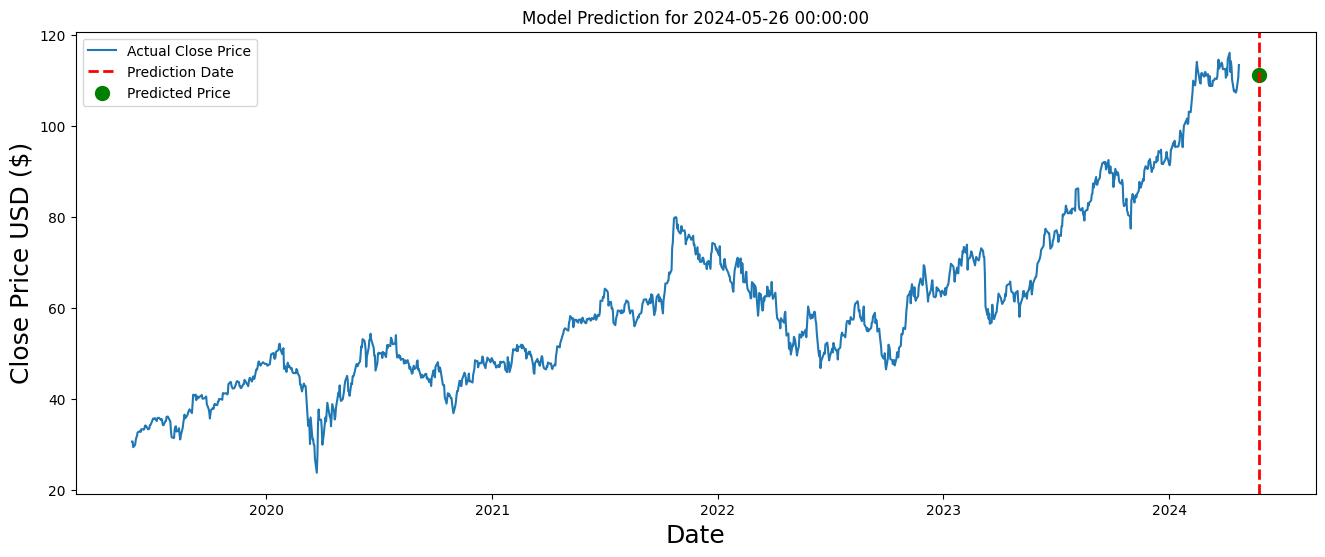

In [8]:
# Function to plot actual vs predicted prices
def plot_predictions(stock_data, predicted_price, prediction_date):
    plt.figure(figsize=(16, 6))
    plt.title('Model Prediction for {}'.format(prediction_date))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(stock_data.index, stock_data.values, label='Actual Close Price')
    plt.axvline(x=prediction_date, color='r', linestyle='--', linewidth=2, label='Prediction Date')
    plt.scatter(prediction_date, predicted_price, color='g', s=100, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.show()

# Entry point of the program
if __name__ == "__main__":
    main()

In [9]:
!pip install pandas_datareader